# Pawdacity New Store Location

Pawdacity is a leading pet store chain in Wyoming with 13 stores throughout the state. This year, Pawdacity would like to expand and open a 14th store. Your manager has asked you to perform an analysis to recommend the city for Pawdacity’s newest store, based on predicted yearly sales. <br><br>
Here are the criterias given to you in choosing the right city:
1.	The new store should be located in a new city. That means there should be no existing stores in the new city.
2.	The total sales for the entire competition in the new city should be less than 500,000 USD.
3.	The new city where you want to build your new store must have a population over 4,000 people (based upon the 2014 US Census estimate).
4.	The predicted yearly sales must be over 200,000 USD.
5.	The city chosen has the highest predicted sales from the predicted set.

## Step 1: Business and Data Understanding

### Key Decisions:

1. Pawdacity wants to open a new pet store. The location should be chosen after a thorough analysis of the surrounding area based on the best predicted yearly sales.

2. To inform this decision, we need the Pawdacity stores’ yearly sales at the city level. We also need information for other predictor variables such as sale volumes of Pawdacity’s competitors in each city, the land area, population density, total families and households with kids under 18 (as families are more likely to have pets and hence to become Pawdacity’s customers).

## Step 2: Building the Training Set

In [1]:
import numpy as np
import pandas as pd
import re
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


### Aggregating sales data from months to years

In [2]:
sales = pd.read_csv('p2-2010-pawdacity-monthly-sales-p2-2010-pawdacity-monthly-sales.csv')

In [3]:
sales.head()

,NAME,ADDRESS,CITY,STATE,ZIP,January,February,March,April,May,June,July,August,September,October,November,December
0,Pawdacity,509 Fort St # A,Buffalo,WY,82834,16200,13392,14688,17064,18360,14040,12960,19224,15984,13392,13176,16848
1,Pawdacity,601 SE Wyoming Blvd Unit 252,Casper,WY,82609,29160,21600,27000,27648,29160,27216,25488,25704,22896,25272,28944,27648
2,Pawdacity,3769 E Lincolnway,Cheyenne,WY,82001,79920,70632,79056,77544,73656,77976,73872,77544,78516,74520,74736,79920
3,Pawdacity,2625 Big Horn Ave,Cody,WY,82414,19440,15984,19008,18144,16632,17496,18792,20304,19224,18144,18576,16632
4,Pawdacity,123 S 2nd St,Douglas,WY,82633,16200,13392,14688,17064,18360,14040,12960,19224,15984,29808,17496,18792


In [4]:
sales_months = sales.iloc[:, 5:].T
sales_months

,0,1,2,3,4,5,6,7,8,9,10
January,16200,29160,79920,19440,16200,24840,47520,20520,27000,21600,27000
February,13392,21600,70632,15984,13392,21168,41796,17928,22032,19872,26352
March,14688,27000,79056,19008,14688,21600,48384,20304,28512,22248,28080
April,17064,27648,77544,18144,17064,22248,47088,21168,26784,20952,22032
May,18360,29160,73656,16632,18360,24192,42336,21600,25920,17496,21168
June,14040,27216,77976,17496,14040,24624,41904,17928,24192,24840,29376
July,12960,25488,73872,18792,12960,25488,42120,18144,25056,22464,25920
August,19224,25704,77544,20304,19224,25704,47088,18576,22896,21816,20304
September,15984,22896,78516,19224,15984,22032,49032,20304,25488,21384,33696
October,13392,25272,74520,18144,29808,21168,48168,21168,26352,20304,23760


In [5]:
sales_year = sales_months.sum()
sales_year

0     185328
1     317736
2     917892
3     218376
4     208008
5     283824
6     543132
7     233928
8     303264
9     253584
10    308232
dtype: int64

In [6]:
sales_city = sales['CITY']
df_sales = pd.concat([sales_city, sales_year], axis = 1)
df_sales.columns = ['City', 'Sales']
df_sales

,City,Sales
0,Buffalo,185328
1,Casper,317736
2,Cheyenne,917892
3,Cody,218376
4,Douglas,208008
5,Evanston,283824
6,Gillette,543132
7,Powell,233928
8,Riverton,303264
9,Rock Springs,253584


### cleaning and joining census data with sales data

In [7]:
census = pd.read_csv('p2-partially-parsed-wy-web-scrape.csv')
census.head()

,City|County,2014 Estimate,2010 Census,2000 Census
0,Afton|Lincoln,"<td>1,968</td>","<td>1,911</td>","<td>1,818</td>"
1,Albin|Laramie,<td>185</td>,<td>181</td>,<td>120</td>
2,Alpine|Lincoln,<td>845</td>,<td>828</td>,<td>550</td>
3,Baggs|Carbon,<td>439</td>,<td>440</td>,<td>348</td>
4,Bairoil|Sweetwater,<td>107</td>,<td>106</td>,<td>97</td>


In [8]:
#removing NaNs
print(census.shape)
census_dropna = census.dropna()
print(census_dropna.shape)

(103, 4)
(99, 4)


In [9]:
cities = census_dropna['City|County'].str.split("|")
city = [city for city, _ in cities]
city = [re.sub("[^a-zA-Z0-9 -]", "", c) for c in city]
city = [c.strip() for c in city]
print(city)

['Afton', 'Albin', 'Alpine', 'Baggs', 'Bairoil', 'Bar Nunn', 'Basin', 'Bear River', 'Big Piney', 'Buffalo', 'Burlington', 'Burns', 'Byron', 'Casper', 'Cheyenne', 'Chugwater', 'Clearmont', 'Cody', 'Cokeville', 'Cowley', 'Dayton', 'Deaver', 'Diamondville', 'Dixon', 'Douglas', 'Dubois', 'East Thermopolis', 'Edgerton', 'Elk Mountain', 'Evanston', 'Evansville', 'Fort Laramie', 'Frannie', 'Gillette', 'Glendo', 'Glenrock', 'Grand Encampment', 'Granger', 'Green River', 'Greybull', 'Guernsey', 'Hanna', 'Hartville', 'Hudson', 'Hulett', 'Jackson', 'Kaycee', 'Kemmerer', 'Kirby', 'La Barge', 'La Grange', 'Lander', 'Laramie', 'Lingle', 'Lost Springs', 'Lovell', 'Lusk', 'Lyman', 'Manderson', 'Manville', 'Marbleton', 'Medicine Bow', 'Meeteetse', 'Midwest', 'Mills', 'Moorcroft', 'Mountain View', 'Newcastle', 'Opal', 'Pavillion', 'Pine Bluffs', 'Pine Haven', 'Pinedale', 'Powell', 'Ranchester', 'Rawlins', 'Riverside', 'Riverton', 'Rock River', 'Rock Springs', 'Rolling Hills', 'Saratoga', 'Sheridan', 'Sho

In [10]:
census2010 = census_dropna['2010 Census'].str.replace(",","")
census2010 = [int(re.sub("[^0-9]", "", c)) for c in census2010]
print(census2010)

[1911, 181, 828, 440, 106, 2213, 1285444, 518, 552, 4585, 288, 301, 593, 35316, 59466, 212, 142, 9520, 535, 655, 757, 178, 737, 97, 6120, 971, 254, 195, 191, 12359, 2544, 230, 157, 29087, 205, 2576, 450, 139, 12515, 1847, 1147, 841, 62, 458, 383, 9577, 263, 2656, 92, 551, 448, 7487, 30816, 468, 4, 2360, 1567, 2115, 114, 95, 1094, 284, 327, 404, 3461, 1009, 1286, 3532, 96, 231, 1129, 490, 2030, 6314, 855, 9259, 52, 10615, 245, 23036, 440, 1690, 17444, 649, 433, 1503, 1182, 336, 260, 366555, 3009, 6501, 1100, 15, 451, 3627, 5487, 1807, 151]


In [11]:
df_census = pd.DataFrame({'City': city, 'Census2010': census2010})
df_census.head()

,City,Census2010
0,Afton,1911
1,Albin,181
2,Alpine,828
3,Baggs,440
4,Bairoil,106


In [12]:
# add Census2014 we will need in the predictive part
census2014 = census_dropna['2014 Estimate'].str.replace(",","")
census2014 = [int(re.sub("[^0-9]", "", c)) for c in census2014]
df_census_2014 = pd.DataFrame({'City': city, 'Census2014': census2014})
df_census_2014.head()

,City,Census2014
0,Afton,1968
1,Albin,185
2,Alpine,845
3,Baggs,439
4,Bairoil,107


### Joining sales data and census data

In [13]:
df = pd.merge(df_sales, df_census, on='City', how='inner')
df

,City,Sales,Census2010
0,Buffalo,185328,4585
1,Casper,317736,35316
2,Cheyenne,917892,59466
3,Cody,218376,9520
4,Douglas,208008,6120
5,Evanston,283824,12359
6,Gillette,543132,29087
7,Powell,233928,6314
8,Riverton,303264,10615
9,Rock Springs,253584,23036


### Adding demographic data

In [14]:
df_demographic = pd.read_csv('p2-wy-demographic-data.csv')
df_demographic.head()

,City,County,Land Area,Households with Under 18,Population Density,Total Families
0,Laramie,Albany,2513.745235,2075,5.19,4668.93
1,Rock River,Albany,200.444000,165,0.41,372.30
2,Basin,Big Horn,543.951304,250,0.66,566.43
3,Burlington,Big Horn,137.646214,63,0.17,143.34
4,Byron,Big Horn,252.489592,116,0.31,262.93


In [15]:
df_cleaned = pd.merge(df, df_demographic, on='City', how='inner')
df = df_cleaned.drop('County', axis=1)

In [16]:
df.columns = ['City', 'Sales', 'Census2010', 'Land_area', 'Households_U18', 'Pop_density', 'Families']
df

,City,Sales,Census2010,Land_area,Households_U18,Pop_density,Families
0,Buffalo,185328,4585,3115.507500,746,1.55,1819.50
1,Casper,317736,35316,3894.309100,7788,11.16,8756.32
2,Cheyenne,917892,59466,1500.178400,7158,20.34,14612.64
3,Cody,218376,9520,2998.956960,1403,1.82,3515.62
4,Douglas,208008,6120,1829.465100,832,1.46,1744.08
5,Evanston,283824,12359,999.497100,1486,4.95,2712.64
6,Gillette,543132,29087,2748.852900,4052,5.80,7189.43
7,Powell,233928,6314,2673.574550,1251,1.62,3134.18
8,Riverton,303264,10615,4796.859815,2680,2.34,5556.49
9,Rock Springs,253584,23036,6620.201916,4022,2.78,7572.18


## Step 3:  Checking for Outliers

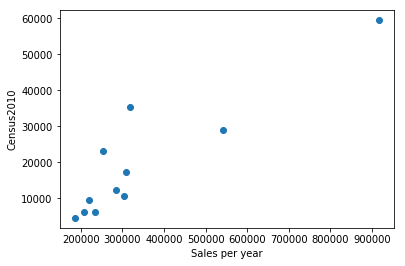

In [17]:
plt.scatter(df['Sales'], df['Census2010']);
plt.xlabel('Sales per year');
plt.ylabel('Census2010');


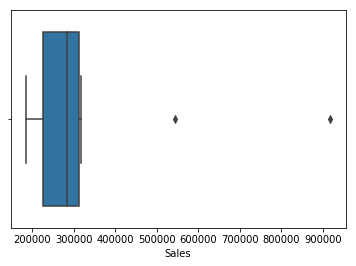

In [18]:
sns.boxplot(x=df['Sales']);

Interpretation: 
from the plots above, we can conclude that there is one outlier city with the yearly sales over $900000. We need to remove it or it would bias the results of the regression model to be done in the next step. 

In [20]:
#removing outlier with Sales value over 800.000
df = df[df['Sales']<800000]

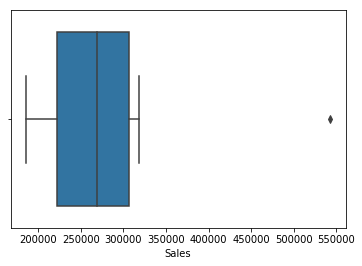

In [21]:
sns.boxplot(x=df['Sales']);

## Step 4: Regression Model

In [23]:
# checking for correlations between  predictor variables to avoid multicollinearity
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Sales,Census2010,Land_area,Households_U18,Pop_density,Families
Sales,1,0.68,-0.031,0.49,0.49,0.61
Census2010,0.68,1,0.32,0.94,0.79,0.92
Land_area,-0.031,0.32,1,0.44,-0.11,0.56
Households_U18,0.49,0.94,0.44,1,0.77,0.91
Pop_density,0.49,0.79,-0.11,0.77,1,0.69
Families,0.61,0.92,0.56,0.91,0.69,1


Interpretation: We can see that HHU18, Census, Families, and Population Density have strong correlations which each other. Land area however, is not as highly correlated. 

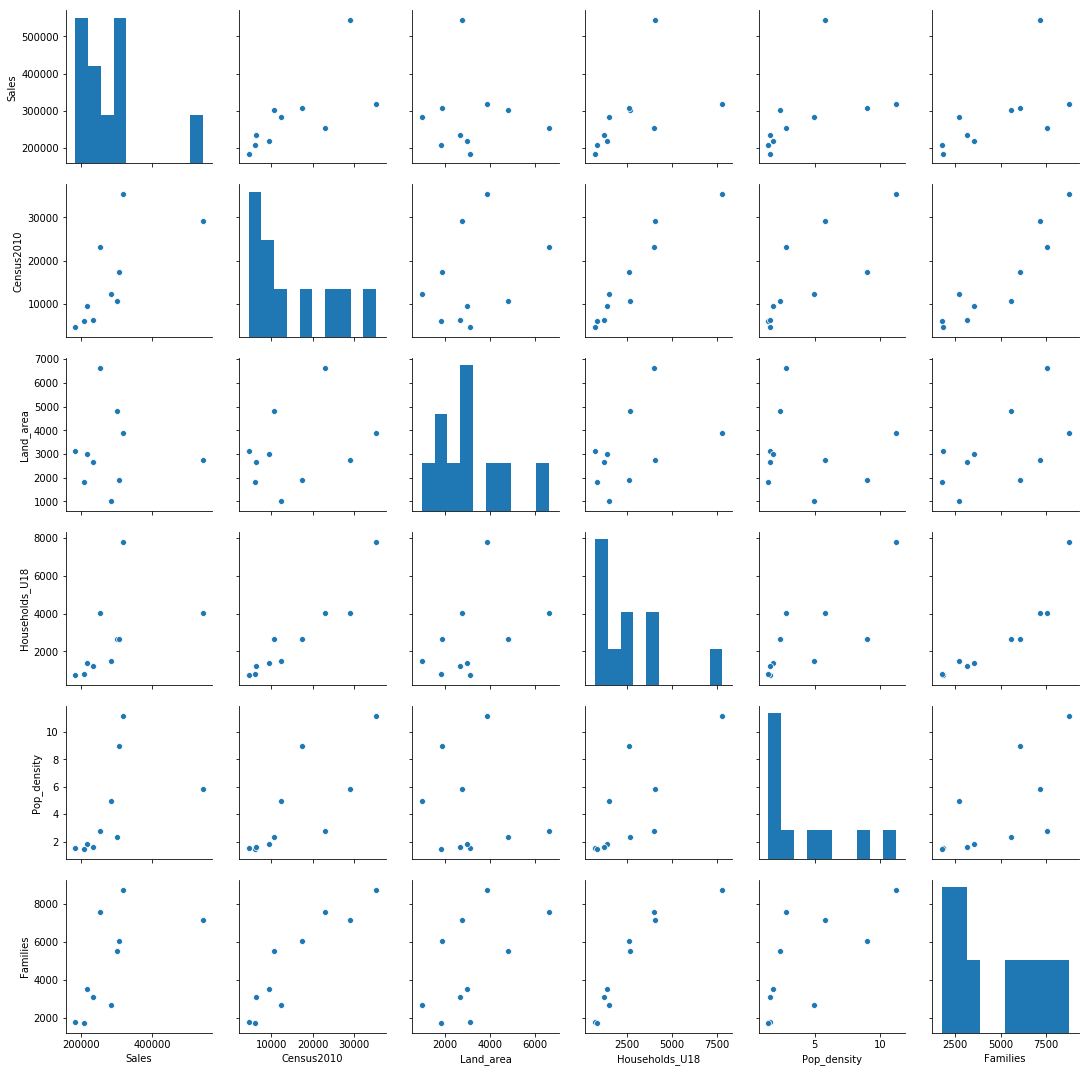

In [24]:
sns.pairplot(df);

Let's check VIFs. if >10 (rule of thumb), then multicollinearity in the model

In [25]:
y, X = dmatrices('Sales ~ Census2010 + Land_area + Households_U18 + Pop_density + Families', df, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,17.667641,Intercept
1,19.815571,Census2010
2,9.190973,Land_area
3,18.646707,Households_U18
4,10.842228,Pop_density
5,20.391913,Families


In [26]:
# let's remove Census2010 to see if multicollinearity diminishes
y, X = dmatrices('Sales ~ Land_area + Households_U18 + Families', df, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,7.254159,Intercept
1,1.537439,Land_area
2,6.234363,Households_U18
3,7.362032,Families


In [27]:
df['intercept'] = 1
lm = sm.OLS(df['Sales'], df[['Land_area','Households_U18', 'Families', 'Pop_density', 'intercept']])
results = lm.fit()
results.summary()

/Users/kbosko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/kbosko/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     6.111
Date:                Sat, 16 Mar 2019   Prob (F-statistic):             0.0365
Time:                        16:26:24   Log-Likelihood:                -120.06
No. Observations:                  10   AIC:                             250.1
Df Residuals:                       5   BIC:                             251.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Land_area        -94.9037     27.537     -3.446      0.018    -165.689     -24.118
Households_U18     7.3573     26.411      0.279      0.792     -60.535      75.249
Families          89.4125     23.258      3.844      0.012      29.627     149.198
Pop_density    -3.963e+04   1.65e+04     -2.403      0.061    -8.2e+04    2755.549
intercept       3.041e+05   6.62e+04      4.594      0.006    1.34e+05    4.74e+05
==============================================================================
Omnibus:                        1.151   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.562   Jarque-Bera (JB):                0.856
Skew:                           0.485   Prob(JB):                        0.652
Kurtosis:                       1.945   Cond. No.                     2.68e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Interpretation: in the model above Households_U18 is not statistically significant, so let's remove it from the model.

In [28]:
lm1 = sm.OLS(df['Sales'], df[['Land_area', 'Families', 'Pop_density', 'intercept']])
results = lm1.fit()
results.summary()

/Users/kbosko/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     9.598
Date:                Sat, 16 Mar 2019   Prob (F-statistic):             0.0105
Time:                        16:26:28   Log-Likelihood:                -120.14
No. Observations:                  10   AIC:                             248.3
Df Residuals:                       6   BIC:                             249.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Land_area     -91.8273     23.205     -3.957      0.007    -148.608     -35.046
Families       91.5522     20.195      4.533      0.004      42.137     140.967
Pop_density -3.699e+04   1.24e+04     -2.984      0.025   -6.73e+04   -6652.414
intercept    2.927e+05   4.78e+04      6.127      0.001    1.76e+05     4.1e+05
==============================================================================
Omnibus:                        1.206   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.547   Jarque-Bera (JB):                0.869
Skew:                           0.475   Prob(JB):                        0.648
Kurtosis:                       1.912   Cond. No.                     1.87e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Interpretation**:<br>
The p-values for all variables in the above mentioned model are below 0.05 and the Multiple R-squared value is 0.828 which is rather high. That is why this model is a decent model.


## Step 4: Preparing Dataset for Predictive Modeling

In [29]:
competition = pd.read_csv('p2-wy-453910-naics-data.csv')
competition.head()

,BUSINESS NAME,PHYSICAL CITY NAME,SALES VOLUME,CASS_LastLine
0,Mile High Mobile Pet LLC,Cheyenne,300000,"Cheyenne, WY 82007-3528"
1,Pets City Inc,Cheyenne,640000,"Cheyenne, WY 82009-4851"
2,Petco Animal Sups Stores Inc,Cheyenne,0,"Cheyenne, WY 82009-4945"
3,Pet-A-Care,Cheyenne,81000,"Cheyenne, WY 82009-1009"
4,Muddy Paws Pet Salon,Laramie,76000,"Laramie, WY 82070-8979"


In [30]:
competition = competition.drop(['BUSINESS NAME', 'CASS_LastLine'], axis=1)
competition.columns = ['City', 'Sales']

In [31]:
comp = competition.groupby(['City'])['Sales'].sum()
df_competition = comp.reset_index()
df_competition

,City,Sales
0,Alpine,70000
1,Casper,210000
2,Cheyenne,1021000
3,Douglas,96000
4,Dubois,55000
5,Evanston,89000
6,Evansville,210000
7,Gillette,1130000
8,Jackson,182000
9,Kemmerer,69000


In [32]:
df_c = pd.merge(df_competition, df_demographic, on='City', how='inner')
df_c

,City,Sales,County,Land Area,Households with Under 18,Population Density,Total Families
0,Alpine,70000,Lincoln,366.598892,213,0.40,446.72
1,Casper,210000,Natrona,3894.309100,7788,11.16,8756.32
2,Cheyenne,1021000,Laramie,1500.178400,7158,20.34,14612.64
3,Douglas,96000,Converse,1829.465100,832,1.46,1744.08
4,Dubois,55000,Fremont,437.073505,244,0.21,506.29
5,Evanston,89000,Uinta,999.497100,1486,4.95,2712.64
6,Evansville,210000,Natrona,215.894254,432,0.62,873.51
7,Gillette,1130000,Campbell,2748.852900,4052,5.80,7189.43
8,Jackson,182000,Teton,1757.659200,1078,2.36,2313.08
9,Kemmerer,69000,Lincoln,1185.264109,690,1.29,1444.32


In [33]:
df_competition = pd.merge(df_c, df_census_2014, on='City', how='inner')
df_comp = df_competition.drop('County', axis=1)
df_comp.columns = ['City', 'Competitor_Sales', 'Land_area', 'Households_U18', 'Pop_density', 'Families', 'Census2014']
df_comp.head()


,City,Competitor_Sales,Land_area,Households_U18,Pop_density,Families,Census2014
0,Alpine,70000,366.598892,213,0.40,446.72,845
1,Casper,210000,3894.309100,7788,11.16,8756.32,40086
2,Cheyenne,1021000,1500.178400,7158,20.34,14612.64,62845
3,Douglas,96000,1829.465100,832,1.46,1744.08,6423
4,Dubois,55000,437.073505,244,0.21,506.29,998


## Step 5: Predicting Sales in potential Cities

In [34]:
df_comp['intercept'] = 1
X = df_comp[['Land_area', 'Families', 'Pop_density', 'intercept']]
sales_pred = results.predict(X)
df_comp['Sales_pred'] = round(sales_pred,2)
df_comp.head()

,City,Competitor_Sales,Land_area,Households_U18,Pop_density,Families,Census2014,intercept,Sales_pred
0,Alpine,70000,366.598892,213,0.40,446.72,845,1,285119.76
1,Casper,210000,3894.309100,7788,11.16,8756.32,40086,1,323960.30
2,Cheyenne,1021000,1500.178400,7158,20.34,14612.64,62845,1,740423.87
3,Douglas,96000,1829.465100,832,1.46,1744.08,6423,1,230358.54
4,Dubois,55000,437.073505,244,0.21,506.29,998,1,291129.59


## Step 6: Filtering Data according to provided criteria for the new city

Here we check all our criterias specified by the manager one by one:

1. The new store should be located in a new city. That means there should be no existing stores in the new city. <br>


In [54]:
df_newcities = df_comp[~df_comp['City'].isin(df['City'])]
df_newcities

,City,Competitor_Sales,Land_area,Households_U18,Pop_density,Families,Census2014,intercept,Sales_pred
0,Alpine,70000,366.598892,213,0.40,446.72,845,1,285119.76
2,Cheyenne,1021000,1500.178400,7158,20.34,14612.64,62845,1,740423.87
4,Dubois,55000,437.073505,244,0.21,506.29,998,1,291129.59
6,Evansville,210000,215.894254,432,0.62,873.51,2831,1,329894.95
8,Jackson,182000,1757.659200,1078,2.36,2313.08,10449,1,255757.06
9,Kemmerer,69000,1185.264109,690,1.29,1444.32,2732,1,268357.89
10,Lander,152197,3346.809340,1870,1.63,3876.81,7642,1,279993.25
11,Laramie,76000,2513.745235,2075,5.19,4668.93,32081,1,297337.39
13,Saratoga,83000,976.042427,240,0.24,499.23,1692,1,239881.57
14,Torrington,876991,1599.818493,1034,4.39,2548.50,6736,1,216720.47


2. The total sales for the entire competition in the new city should be less than 500,000 USD. 

In [57]:
df_newcities = df_newcities[df_newcities['Competitor_Sales'] < 500000]
df_newcities

,City,Competitor_Sales,Land_area,Households_U18,Pop_density,Families,Census2014,intercept,Sales_pred
0,Alpine,70000,366.598892,213,0.40,446.72,845,1,285119.76
4,Dubois,55000,437.073505,244,0.21,506.29,998,1,291129.59
6,Evansville,210000,215.894254,432,0.62,873.51,2831,1,329894.95
8,Jackson,182000,1757.659200,1078,2.36,2313.08,10449,1,255757.06
9,Kemmerer,69000,1185.264109,690,1.29,1444.32,2732,1,268357.89
10,Lander,152197,3346.809340,1870,1.63,3876.81,7642,1,279993.25
11,Laramie,76000,2513.745235,2075,5.19,4668.93,32081,1,297337.39
13,Saratoga,83000,976.042427,240,0.24,499.23,1692,1,239881.57
15,Wheatland,77000,1430.510450,662,2.86,1754.34,3659,1,216150.80
16,Worland,169000,1294.105755,595,2.18,1364.32,5366,1,218120.53


3. The new city where you want to build your new store must have a population over 4,000 people (based upon the 2014 US Census estimate).

In [60]:
df_newcities = df_newcities[df_newcities['Census2014'] > 4000]
df_newcities

,City,Competitor_Sales,Land_area,Households_U18,Pop_density,Families,Census2014,intercept,Sales_pred
8,Jackson,182000,1757.659200,1078,2.36,2313.08,10449,1,255757.06
10,Lander,152197,3346.809340,1870,1.63,3876.81,7642,1,279993.25
11,Laramie,76000,2513.745235,2075,5.19,4668.93,32081,1,297337.39
16,Worland,169000,1294.105755,595,2.18,1364.32,5366,1,218120.53


4. The predicted yearly sales must be over 200,000 USD.

In [63]:
df_newcities = df_newcities[df_newcities['Sales_pred'] > 200000]
df_newcities

,City,Competitor_Sales,Land_area,Households_U18,Pop_density,Families,Census2014,intercept,Sales_pred
8,Jackson,182000,1757.659200,1078,2.36,2313.08,10449,1,255757.06
10,Lander,152197,3346.809340,1870,1.63,3876.81,7642,1,279993.25
11,Laramie,76000,2513.745235,2075,5.19,4668.93,32081,1,297337.39
16,Worland,169000,1294.105755,595,2.18,1364.32,5366,1,218120.53


5. The city chosen has the highest predicted sales from the predicted set.

In [64]:
df_newcities.sort_values(by='Sales_pred', ascending=False)

,City,Competitor_Sales,Land_area,Households_U18,Pop_density,Families,Census2014,intercept,Sales_pred
11,Laramie,76000,2513.745235,2075,5.19,4668.93,32081,1,297337.39
10,Lander,152197,3346.809340,1870,1.63,3876.81,7642,1,279993.25
8,Jackson,182000,1757.659200,1078,2.36,2313.08,10449,1,255757.06
16,Worland,169000,1294.105755,595,2.18,1364.32,5366,1,218120.53


## Conclusion:

Based on the analysis, I would recommend Pawdacity to open a new store in Laramie with a predicted sales of $297,000.